In [1]:
import numpy as np
import pandas as pd
import scipy.stats as scs
from numpy import mean, std
from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm

np.random.seed(0)

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import log_loss, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import r2_score
from collections import defaultdict

In [4]:
covid = pd.read_csv('../data/full_feature_covid.csv')
covid = covid.set_index('GEOID')

#clean up nans
covid = covid.fillna(0)

#break out categorical data
covid = pd.get_dummies(covid, columns=['DominantReligion','Region'])

#save georegion for later
geocols = ['Geographical_Point','Target_PctChg']
geo = covid[geocols]

#Drop categorical columns that won't help with our model
cols = ['County', 'State','Geographical_Point']
covid = covid.drop(cols, axis = 1)

#normalize data
covid['Target_PctChg'] = covid['Target_PctChg']/10
covid['Unempl_Rate'] = covid['Unempl_Rate']/100
covid['Median_HHI'] = covid['Median_HHI']/covid['Median_HHI'].sum()
covid['DensPerSqMile'] = covid['DensPerSqMile']/covid['DensPerSqMile'].sum()
covid['Avg_HH_Size'] = covid['Avg_HH_Size']/10
covid['Avg_Fam_Size'] = covid['Avg_Fam_Size']/10
covid.mean(axis=0)

covid.head()

X = covid.copy()
y = X.pop('Target_PctChg')

X_train, X_test, y_train, y_test = train_test_split(X.astype(float), y, test_size=0.2, random_state=1) 

#mean is the baseline for all models
mean_arr = np.zeros(y_test.shape)
mean_arr[mean_arr==0] = y.mean()
y_hat_mean = mean_arr


In [37]:
#linear regression
summ = summary_model(X_train,y_train)

#linear regression
ols = linear_model.LinearRegression()
model = ols.fit(X_train, y_train)
y_hat_ols = model.predict(X_test)
mse_ols = mean_squared_error(y_hat_ols, y_test)
mse_ols

0.012417500557362534

In [6]:
#decision tree
dt = DecisionTreeRegressor(max_depth=6)
dt.fit(X_train, y_train)
y_hat_dt = dt.predict(X_test)
mse_dt = mean_squared_error(y_hat_dt, y_test)

In [7]:
#random Forest - base model
model = RandomForestRegressor(n_estimators=100, bootstrap=True, max_features='sqrt')
model.fit(X_train, y_train)
# Actual class predictions
rf_predictions_base = model.predict(X_test)
mse_rf_base = mean_squared_error(rf_predictions_base, y_test)

In [34]:
print(gridsearch(X, y))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}


In [38]:
#random forest - best model based on 
best_model = RandomForestRegressor(n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features='sqrt', max_depth=20, bootstrap=False)
best_model.fit(X_train, y_train)
# Actual class predictions
rf_predictions_best = best_model.predict(X_test)
mse_rf_best = mean_squared_error(rf_predictions_best, y_test)
#{'n_estimators': 800, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}

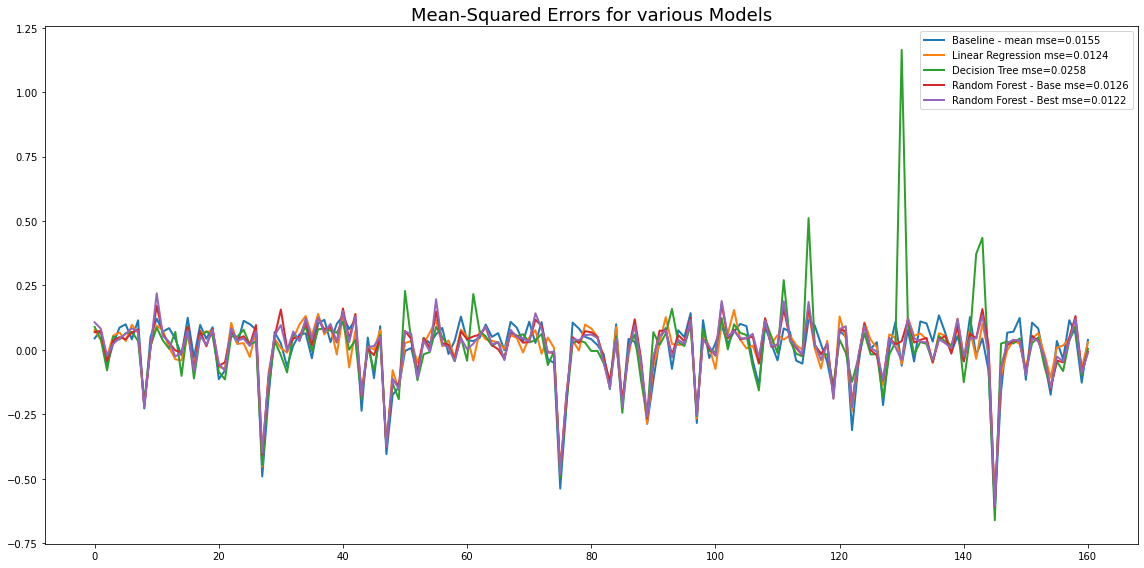

In [43]:
#graph errors
datapoints = list(range(len(y_test)))

fig, ax = plt.subplots(figsize=(16,8))

ax.plot(datapoints, y_hat_mean - y_test, lw = 2, label='Baseline - mean mse={:.4f}'.format(0.01553))
ax.plot(datapoints, y_hat_ols - y_test, lw=2, label='Linear Regression mse={:.4f}'.format(mean_squared_error(y_hat_ols,y_test)))
ax.plot(datapoints, y_hat_dt - y_test, lw=2, label='Decision Tree mse={:.4f}'.format(mean_squared_error(y_hat_dt, y_test)))
ax.plot(datapoints, rf_predictions_base - y_test, lw=2, label='Random Forest - Base mse={:.4f}'.format(mean_squared_error(rf_predictions_base, y_test)))
ax.plot(datapoints, rf_predictions_best - y_test, lw=2, label='Random Forest - Best mse={:.4f}'.format(0.012212))

ax.set_title('Mean-Squared Errors for various Models', fontsize=18)
plt.legend(loc='best')

fig.tight_layout()
plt.savefig('../img/mse.png', dpi=100)


In [44]:
#Predict the entire data set
all_predictions = best_model.predict(X)
predicted_rate_of_change = np.array(all_predictions*10)
predicted_rate_of_change

array([ 1.22667342e-01, -6.79824311e-02,  1.87885725e-01,  4.54568615e-01,
        1.26522536e+00,  3.39018091e-01,  1.62139269e+00,  1.49256168e+00,
        1.05077437e+00,  3.03943672e+00,  8.54619379e-01,  3.02050726e-01,
        1.32561638e+00,  3.77910483e-01,  1.78373390e-01,  2.76109926e-01,
        4.47500816e-01,  1.38826662e-01,  1.23845566e+00,  1.64778556e-01,
        4.36347371e-01,  1.38395180e+00,  9.74822195e-01,  8.77273947e-01,
        3.20734667e+00,  9.79762539e-01,  2.51090959e+00,  1.53175899e+00,
        7.96227139e-01,  6.94135197e-01,  8.14740340e-01,  1.67754556e+00,
        1.06619139e+00,  1.51473159e+00,  1.72294184e+00,  6.99451273e-01,
        1.22854733e+00,  5.51814473e-01,  1.68720149e+00,  7.00116468e-01,
        1.43522221e+00,  7.95786122e-01,  7.40306416e-01,  7.97612309e-01,
        7.49731777e-01,  8.79851681e-01,  1.41823361e+00,  1.03675043e+00,
        1.35914406e+00,  1.40152163e+00,  1.14984007e+00,  8.82505969e-01,
        7.65850580e-01,  

In [ ]:
#Plot geographic info
geo.info()
geo['NewPrediction'] = predicted_rate_of_change
geo.describe()


In [ ]:
#Feature importance based on random forest
# manual shuffle 
rf = RandomForestRegressor()
scores = defaultdict(list)

names = X.columns
 
rf = RandomForestRegressor()
scores = defaultdict(list)

# crossvalidate the scores on a number of 
# different random splits of the data
splitter = ShuffleSplit(100, test_size=.3)

for train_idx, test_idx in splitter.split(X, y):
    X_train, X_test = X.values[train_idx], X.values[test_idx]
    y_train, y_test = y.values[train_idx], y.values[test_idx]
    rf.fit(X_train, y_train)
    acc = r2_score(y_test, rf.predict(X_test))
    for i in range(X.shape[1]):
        X_t = X_test.copy()
        np.random.shuffle(X_t[:, i])
        shuff_acc = r2_score(y_test, rf.predict(X_t))
        scores[names[i]].append((acc-shuff_acc)/acc)

score_series = pd.DataFrame(scores).mean()
scores = pd.DataFrame({'Mean Decrease Accuracy' : score_series})
scores.sort_values(by='Mean Decrease Accuracy').plot(kind='barh', figsize = (14,10))


In [ ]:
#based on feature importance, compute correlations of significant predictors
for col in cols:
    print('{} {}'.format(col,compute_correlation(covid[col],y)))
    
for col in cols:
    print('{} {}'.format(col,spearmanr(covid[col],y))

In [2]:
#linear regression OLS
def summary_model(X, y, label='scatter'):
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    summary = model.summary()
    return summary

def plot_model(X, y, label='Residual Plot'):
    model = sm.OLS(y, X).fit()
    student_resids = model.outlier_test()['student_resid']
    y_hats = model.predict(X)

    plt.scatter(y_hats, student_resids, alpha = .35, label=label)
    plt.legend()
    plt.show()

def learning_curves(X_train, y_train, X_test, y_test):
    
    fig = plt.figure(figsize=(10,8))
    # Generate 40 evenly spaced numbers (rounded to nearest integer) over a specified interval 1 to 354
    datapoints = np.rint(np.linspace(1, len(X_train), 40)).astype(int)
    #initialise array of shape (40,)
    train_err = np.zeros(len(datapoints))
    test_err = np.zeros(len(datapoints))
 
    # Create 6 different models based on max_depth
    for k, depth in enumerate(range(1,7)):
        for i, s in enumerate(datapoints):
            reg = DecisionTreeRegressor(max_depth = depth) #increasing depth
            # Iteratively increase training set size
            reg.fit(X_train[:s], y_train[:s])
            # MSE for training and test sets of increasing size
            train_err[i] = mean_squared_error(y_train[:s], reg.predict(X_train[:s]))
            test_err[i] = mean_squared_error(y_test, reg.predict(X_test))

        print('Train_error: {}'.format(train_err[-1]))
        print('Test_error: {}'.format(test_err[-1]))
 
        # Subplot learning curves
        sub = fig.add_subplot(3, 3, k+1)
        sub.plot(datapoints, test_err, lw = 1, label = 'Testing Error')
        sub.plot(datapoints, train_err, lw = 1, label = 'Training Error')
        sub.legend()
        sub.set_title('DT Max Depth = %s'%(depth))
        sub.set_xlabel('No. of Data Points in Training Set')
        sub.set_ylabel('Total Error')
        sub.set_xlim([0, len(X_train)])
        
        fig.suptitle('Decision Tree Regressor Learning Curves', fontsize=18, y=1.03)
        fig.tight_layout()
        fig.show()

def bootstrap_confidence_interval(data, function, alpha=0.05, n_bootstraps=1000):
    '''return a the confidence interval for a function of data using bootstrapping'''
    medians = []
    for _ in range(n_bootstraps):
        bootstrap_sample = np.random.choice(data, len(data))
        medians.append(function(bootstrap_sample))
    return (np.percentile(medians, 100*(alpha/2.)),
            np.percentile(medians, 100*(1-alpha/2.))), medians

def gridsearch(x, y):
    # Number of trees in random forest
	n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
	# Number of features to consider at every split
	max_features = ['auto', 'sqrt']
	# Maximum number of levels in tree
	max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
	max_depth.append(None)
	# Minimum number of samples required to split a node
	min_samples_split = [2, 5, 10]
	# Minimum number of samples required at each leaf node
	min_samples_leaf = [1, 2, 4]
	# Method of selecting samples for training each tree
	bootstrap = [True, False]
	# Create the random grid
	random_grid = {'n_estimators': n_estimators,
		'max_features': max_features,
		'max_depth': max_depth,
		'min_samples_split': min_samples_split,
		'min_samples_leaf': min_samples_leaf,
		'bootstrap': bootstrap}

	#print(random_grid)

	# Use the random grid to search for best hyperparameters
	# First create the base model to tune
	rf = RandomForestRegressor()
	# Random search of parameters, using 3 fold cross validation, 
	# search across 100 different combinations, and use all available cores
	rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
	# Fit the random search model
	rf_random.fit(x, y)

	return rf_random.best_params_
